# Quora Question Pairs using MaLSTM 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pickle
import pandas as pd
import numpy as np

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
#from nltk.corpus import stopword
from nltk.stem import WordNetLemmatizer
import re


import seaborn as sns
# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.engine.topology import Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Embedding,Bidirectional,LSTM,Concatenate,GlobalAveragePooling1D,Dropout, Lambda
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from tensorflow import keras


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df = pd.read_csv( "/content/drive/MyDrive/Kaggle/train.csv") 

In [4]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('/content/drive/MyDrive/Kaggle/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [5]:
# Parameters
max_num_words = 200000
sequence_length = 60
embedding_dim = 300

In [24]:
# Preprocessing text

In [7]:
  def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
      # Clean the text, with the option to remove stopwords and to stem words.
      # Convert words to lower case and split them
      text = text.lower().split()

      # Optionally, remove stop words
      if remove_stopwords:
          stop_words = set(stopwords.words("english"))
          text = [w for w in text if not w in stop_words]
      
      text = " ".join(text)
      
      # Remove punctuation from text
      # text = "".join([c for c in text if c not in punctuation])

      # Clean the text
      text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
      text = re.sub(r"what's", "what is ", text)
      text = re.sub(r"\'s", " ", text)
      text = re.sub(r"\'ve", " have ", text)
      text = re.sub(r"can't", "cannot ", text)
      text = re.sub(r"n't", " not ", text)
      text = re.sub(r"i'm", "i am ", text)
      text = re.sub(r"\'re", " are ", text)
      text = re.sub(r"\'d", " would ", text)
      text = re.sub(r"\'ll", " will ", text)
      text = re.sub(r",", " ", text)
      text = re.sub(r"\.", " ", text)
      text = re.sub(r"!", " ! ", text)
      text = re.sub(r"\/", " ", text)
      text = re.sub(r"\^", " ^ ", text)
      text = re.sub(r"\+", " + ", text)
      text = re.sub(r"\-", " - ", text)
      text = re.sub(r"\=", " = ", text)
      text = re.sub(r"'", " ", text)
      text = re.sub(r":", " : ", text)
      text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
      text = re.sub(r" e g ", " eg ", text)
      text = re.sub(r" b g ", " bg ", text)
      text = re.sub(r" u s ", " american ", text)
      # text = re.sub(r"\0s", "0", text) # It doesn't make sense to me
      text = re.sub(r" 9 11 ", "911", text)
      text = re.sub(r"e - mail", "email", text)
      text = re.sub(r"j k", "jk", text)
      text = re.sub(r"\s{2,}", " ", text)
      
      
      # Return a list of words
      return(text)

  def preprocess_prepare(q1, q2):

      #Apply preprocessing on each question
      q1=q1.apply(text_to_wordlist)
      q2=q2.apply(text_to_wordlist)

      return q1,q2

In [8]:
train_df = train_df.fillna("")
train_df['question1_clean'],train_df['question2_clean'] = preprocess_prepare(train_df['question1'], train_df['question2'])

In [9]:
# Tokenize words in all sentences
tokenizer = Tokenizer(num_words = max_num_words, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(train_df['question1_clean']+train_df['question2_clean'])

# this takes questions and replaces each word with an integer
q1 = tokenizer.texts_to_sequences(train_df['question1_clean'])
q2 = tokenizer.texts_to_sequences(train_df['question2_clean'])

# sequence padding to have the same length of sentence (sequence_length)
q1 = pad_sequences(q1, int(sequence_length))
q2 = pad_sequences(q2, int(sequence_length))

In [10]:
y=train_df['is_duplicate']

In [11]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 86391 unique tokens.


In [12]:
embedding_matrix = np.zeros((max_num_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Null word embeddings: '.format(np.sum(np.sum(embedding_matrix, axis=1) == 0)))

Null word embeddings: 


In [13]:
# Number words in each question (might be usueful feature) 
q1_n_words = train_df['question1'].apply(lambda x: len(x.split(' ')))
q2_n_words = train_df['question2'].apply(lambda x: len(x.split(' ')))

In [14]:
# Standarize numerical features 
scaler = MinMaxScaler()

scaler.fit(q1_n_words.values.reshape(1,-1))
q1_n_words=scaler.transform(q1_n_words.values.reshape(1,-1))

scaler.fit(q2_n_words.values.reshape(1,-1))
q2_n_words=scaler.transform(q2_n_words.values.reshape(1,-1))



In [15]:
y=train_df['is_duplicate']

In [16]:
def exponent_neg_manhattan_distance(left, right):
    ''' 
    Purpose : Helper function for the similarity estimate of the LSTMs outputs
    Inputs : Two n-dimensional vectors
    Output : Manhattan distance between the input vectors
    
    '''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [17]:
# Input layers
q1_input = Input(shape=(sequence_length,))
q2_input = Input(shape=(sequence_length,))

embedding_layer = Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1], 
                             weights=[embedding_matrix],input_length = sequence_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(q1_input)
encoded_right = embedding_layer(q2_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(50)

q1_output = shared_lstm(encoded_left)
q2_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
output = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([q1_output, q2_output])

In [18]:
# Combine all of the above in a Model
model = Model([q1_input, q2_input], [output])

In [19]:
model.compile(loss='mse', optimizer= 'adam', metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 300)      60000000    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 50)           70200       embedding[0][0]              

In [21]:
# Set early stopping (large patience should be useful)
early_stopping =EarlyStopping(monitor='val_loss', patience=5)

history = model.fit([q1, q2], y, epochs = 50, batch_size = 2048, verbose = 1, validation_split = 0.1, shuffle = True, callbacks=[early_stopping])

Epoch 1/50
178/178 [==============================] - 23s 106ms/step - loss: 0.2358 - accuracy: 0.6843 - val_loss: 0.1663 - val_accuracy: 0.7542
Epoch 2/50
178/178 [==============================] - 18s 101ms/step - loss: 0.1658 - accuracy: 0.7559 - val_loss: 0.1555 - val_accuracy: 0.7750
Epoch 3/50
178/178 [==============================] - 18s 101ms/step - loss: 0.1552 - accuracy: 0.7763 - val_loss: 0.1500 - val_accuracy: 0.7872
Epoch 4/50
178/178 [==============================] - 18s 101ms/step - loss: 0.1505 - accuracy: 0.7861 - val_loss: 0.1470 - val_accuracy: 0.7950
Epoch 5/50
178/178 [==============================] - 18s 101ms/step - loss: 0.1463 - accuracy: 0.7946 - val_loss: 0.1439 - val_accuracy: 0.7998
Epoch 6/50
178/178 [==============================] - 18s 101ms/step - loss: 0.1434 - accuracy: 0.7994 - val_loss: 0.1416 - val_accuracy: 0.8019
Epoch 7/50
178/178 [==============================] - 18s 100ms/step - loss: 0.1409 - accuracy: 0.8041 - val_loss: 0.1401 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


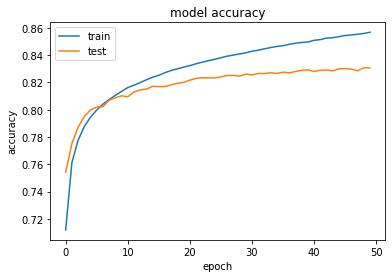

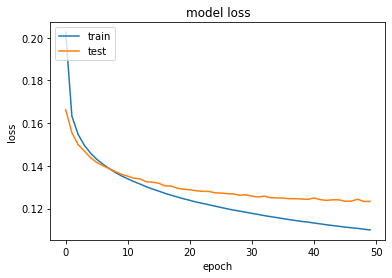

In [22]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# Saving Model
model.save("model.h5")